# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [1]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Vector{Float64}:
 0.7981053971803753
 0.17103550664721845
 0.26248681420870135
 0.9822205545702989
 0.6147596500395106
 0.4651973462422728
 0.9767245560990149
 0.2851017478805482
 0.4805803705876698
 0.8382052889639484
 0.7890014187757277
 0.3111743551696853
 0.06447186122786919
 ⋮
 0.3545102053342859
 0.9519028968135467
 0.8213789651869248
 0.482366874257834
 0.3792054372649749
 0.7120302059067732
 0.47169038008809094
 0.7685324642644052
 0.5857134729234145
 0.6531525485205912
 0.4478216926221066
 0.9123098675063058

In [2]:
sum(a)

4.999934791503921e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [3]:
@time sum(a)

  0.002753 seconds (1 allocation: 16 bytes)


4.999934791503921e6

In [4]:
@time sum(a)

  0.002455 seconds (1 allocation: 16 bytes)


4.999934791503921e6

In [5]:
@time sum(a)

  0.020259 seconds (1 allocation: 16 bytes)


4.999934791503921e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [6]:
using Pkg
Pkg.add("BenchmarkTools")

   Resolving package versions...
  No Changes to `~/Repository/Introduction-to-Julia/Project.toml`
  No Changes to `~/Repository/Introduction-to-Julia/Manifest.toml`


In [7]:
using BenchmarkTools  

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [8]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

clang: warning: argument unused during compilation: '-msse3' [-Wunused-command-line-argument]


c_sum (generic function with 1 method)

In [9]:
c_sum(a)

4.999934791504142e6

In [10]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [11]:
c_sum(a) - sum(a)  

2.207234501838684e-7

In [12]:
≈  # alias for the `isapprox` function

isapprox (generic function with 9 methods)

In [13]:
?isapprox

search: isapprox



```
isapprox(x, y; atol::Real=0, rtol::Real=atol>0 ? 0 : √eps, nans::Bool=false[, norm::Function])
```

Inexact equality comparison. Two numbers compare equal if their relative distance *or* their absolute distance is within tolerance bounds: `isapprox` returns `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significant digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

The `norm` keyword defaults to `abs` for numeric `(x,y)` and to `LinearAlgebra.norm` for arrays (where an alternative `norm` choice is sometimes useful). When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

!!! compat "Julia 1.6"
    Passing the `norm` keyword argument when comparing numeric (non-array) arguments requires Julia 1.6 or later.


# Examples

```jldoctest
julia> isapprox(0.1, 0.15; atol=0.05)
true

julia> isapprox(0.1, 0.15; rtol=0.34)
true

julia> isapprox(0.1, 0.15; rtol=0.33)
false

julia> 0.1 + 1e-10 ≈ 0.1
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0]) # using `norm`
true
```

---

```
isapprox(x; kwargs...) / ≈(x; kwargs...)
```

Create a function that compares its argument to `x` using `≈`, i.e. a function equivalent to `y -> y ≈ x`.

The keyword arguments supported here are the same as those in the 2-argument `isapprox`.

!!! compat "Julia 1.5"
    This method requires Julia 1.5 or later.



We can now benchmark the C code directly from Julia:

In [14]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 389 samples with 1 evaluation per sample.
 Range (min … max):  12.510 ms … 12.984 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     12.553 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   12.577 ms ± 78.198 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▅▇▇██▆▆▆▆▅▅▆▃▂ ▁  ▁                                          
  ████████████████▁██▅▅▆▅▅▅▅█▁▁▅▅▆▆▁▇▆▅▅▁▆▅▁▆▅▅▁▅▅▁▅▁▁▆▁▁▁▁▁▅ ▇
  12.5 ms      Histogram: log(frequency) by time      12.9 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [15]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 12.510041 msec


In [16]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 1 entry:
  "C" => 12.51

In [17]:
using Plots
gr()

Plots.GRBackend()

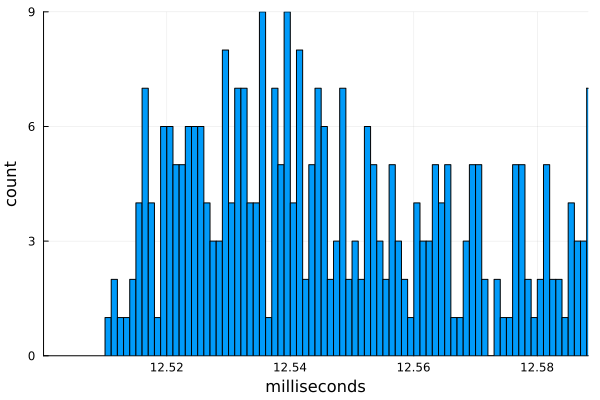

In [18]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. C with -ffast-math

If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.

In [19]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

clang: warning: argument unused during compilation: '-msse3' [-Wunused-command-line-argument]


c_sum_fastmath (generic function with 1 method)

In [20]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 1487 samples with 1 evaluation per sample.
 Range (min … max):  1.721 ms …   4.135 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.341 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.347 ms ± 141.423 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                                                 ▆█▆▄▄▂▁       
  ▄▁▄▁▁▁▁▁▁▁▁▁▄▁▁▄▄▁▁▁▁▁▄▅▁▄▅▄▄▁▄▆▄▁▄▄▄▁▄▆▆▁▄▄▄▁▇███████▇▇▇▅▇ █
  1.72 ms      Histogram: log(frequency) by time      3.69 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [21]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

1.720958

# 3. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [22]:
using Pkg; Pkg.add("PyCall")
using PyCall

   Resolving package versions...
  No Changes to `~/Repository/Introduction-to-Julia/Project.toml`
  No Changes to `~/Repository/Introduction-to-Julia/Manifest.toml`


In [23]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [24]:
pysum(a)

4.999934791504142e6

In [25]:
pysum(a) ≈ sum(a)

true

In [26]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 10 samples with 1 evaluation per sample.
 Range (min … max):  535.842 ms … 545.952 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     537.529 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   538.594 ms ±   2.970 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁    ▁▁▁ ▁▁▁               █                                ▁  
  █▁▁▁▁███▁███▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  536 ms           Histogram: frequency by time          546 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [27]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"               => 12.51
  "Python built-in" => 535.842
  "C -ffast-math"   => 1.72096

# 4. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [28]:
using Pkg; Pkg.add("Conda")
using Conda

   Resolving package versions...
  No Changes to `~/Repository/Introduction-to-Julia/Project.toml`
  No Changes to `~/Repository/Introduction-to-Julia/Manifest.toml`


In [29]:
Conda.add("numpy")

[ Info: Running `conda install -y numpy` in root environment


Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 25.3.1

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=25.3.1




In [30]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 1685 samples with 1 evaluation per sample.
 Range (min … max):  2.454 ms …   9.955 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.126 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.954 ms ± 384.911 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▃▂▅▄▄▄▃▃▂▁                       ▃█▇▅▃▂▁▁                   ▁
  ███████████▇▆▅▄▆▄▅▅▅▄▅▅▁▄▅▄▅▄▄▆██████████▇▇▆▁▄▁▁▄▁▄▁▅▆██▆▆▆ █
  2.45 ms      Histogram: log(frequency) by time      3.61 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [31]:
numpy_sum(a)

4.999934791503916e6

In [32]:
numpy_sum(a) ≈ sum(a)

true

In [33]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any, Any} with 4 entries:
  "C"               => 12.51
  "Python numpy"    => 2.45375
  "Python built-in" => 535.842
  "C -ffast-math"   => 1.72096

# 5. Python, hand-written 

In [34]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x369779bd0>

In [35]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 8 samples with 1 evaluation per sample.
 Range (min … max):  667.097 ms … 674.007 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     667.687 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   669.099 ms ±   2.578 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁ ▁ █▁            ▁                         ▁               ▁  
  █▁█▁██▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  667 ms           Histogram: frequency by time          674 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [36]:
sum_py(a)

4.999934791504142e6

In [37]:
sum_py(a) ≈ sum(a)

true

In [38]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "C"                   => 12.51
  "Python numpy"        => 2.45375
  "Python hand-written" => 667.097
  "Python built-in"     => 535.842
  "C -ffast-math"       => 1.72096

# 6. Julia (built-in) 

## Written directly in Julia, not in C!

In [39]:
@which sum(a)

sum(a::AbstractArray; dims, kw...)
     @ Base reducedim.jl:994

In [40]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 1576 samples with 1 evaluation per sample.
 Range (min … max):  2.267 ms …   5.472 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.385 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.159 ms ± 541.381 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▆▂▆▅▂               ▂▃▂▁    ▄█▇▅▄▃▂▁▂▁                      ▁
  █████▇▆▇▅▆█▁▆▁▁▅▇▅▅██████▆▇▅███████████▇█▇█▆▆▆▇▆▆▅▆▆▅▄▅▁▄▅▅ █
  2.27 ms      Histogram: log(frequency) by time       4.5 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [41]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any, Any} with 6 entries:
  "C"                   => 12.51
  "Python numpy"        => 2.45375
  "Python hand-written" => 667.097
  "Python built-in"     => 535.842
  "Julia built-in"      => 2.26679
  "C -ffast-math"       => 1.72096

# 7. Julia (hand-written) 

In [42]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [43]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 397 samples with 1 evaluation per sample.
 Range (min … max):  12.509 ms … 12.951 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     12.567 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   12.597 ms ± 85.863 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▃▃█▁▃▆▂▆▄ ▂                                                 
  ██████████▇█▅▆▆▄▆▄▄▆▃▃▂▃▃▁▄▃▃▃▂▃▄▃▄▃▃▄▃▃▃▃▁▃▃▃▁▁▂▂▂▂▂▂▁▁▁▁▃ ▃
  12.5 ms         Histogram: frequency by time        12.9 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [44]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any, Any} with 7 entries:
  "C"                   => 12.51
  "Python numpy"        => 2.45375
  "Julia hand-written"  => 12.5095
  "Python hand-written" => 667.097
  "Python built-in"     => 535.842
  "Julia built-in"      => 2.26679
  "C -ffast-math"       => 1.72096

# 8. Julia (hand-written w. simd) 

In [45]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [46]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 1407 samples with 1 evaluation per sample.
 Range (min … max):  3.436 ms …   4.784 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.506 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.537 ms ± 115.991 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▄▆█▆▃▂▁                                                    
  ▄████████▆▇▅▄▅▅▃▄▄▄▃▃▂▂▃▃▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁▁▁▂▁▂▂▂▁▁▂▁▂ ▃
  3.44 ms         Histogram: frequency by time        4.12 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [47]:
mysum_simd(a)

4.999934791503994e6

In [48]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any, Any} with 8 entries:
  "Julia hand-written simd" => 3.43642
  "C"                       => 12.51
  "Python numpy"            => 2.45375
  "Julia hand-written"      => 12.5095
  "Python hand-written"     => 667.097
  "Python built-in"         => 535.842
  "Julia built-in"          => 2.26679
  "C -ffast-math"           => 1.72096

# Summary

In [49]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

C -ffast-math...............1.7
Julia built-in..............2.3
Python numpy................2.5
Julia hand-written simd.....3.4
Julia hand-written.........12.5
C..........................12.5
Python built-in...........535.8
Python hand-written.......667.1
